Quick look at variance as a function of flux for an HSC warp image.

Original Analysis section works as intended.

TO-DO: get the rest of the sections to show different plots.

## Imports

In [1]:
REPO = '/sdf/data/rubin/repo/main/'

from lsst.daf.butler import Butler
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

butler = Butler(REPO)
registry = butler.registry

## Define parameters

### Collection parameters

The collection is data that has been already run through the `make_direct_warp` and `assemble_cell_coadd` tasks in the Science Pipelines.

In [2]:
collection = 'u/mgorsuch/assemble_cell_coadds_tract_9813/20240624T164450Z' # all working patches in tract 9813

Patches to choose from: [37, 38, 39, 40, 41, 44, 45, 46, 48, 49, 50, 51, 52, 55, 56, 57, 60, 61, 62, 63, 67, 83, 84]

In [3]:
patch = 50

In [4]:
# get the list of visits in this patch found in this collection
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC', tract=9813, skymap = 'hsc_rings_cells_v1', patch=patch):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)

The list of visit IDs will tell us how many warps we can look at in this patch, and which ones.

In [5]:
print(visits)

[ 1242  1248 19680 19684 19694 19696 30490]


### Define warp variables

In [6]:
# read in an example warp
warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = patch,
                   visit = 1242)

In [7]:
# read in the image, variance, and mask planes of the warp.
warp_im = warp.image.array.flatten()
warp_var = warp.variance.array.flatten()
warp_mask = warp.mask.array.flatten()

The mask plane of the warp will contain the bit masks used in the visit.

In [8]:
print(warp.mask.getMaskPlaneDict())

{'BAD': 0, 'CR': 3, 'CROSSTALK': 9, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INTRP': 2, 'NOT_DEBLENDED': 10, 'NO_DATA': 8, 'SAT': 1, 'STREAK': 11, 'SUSPECT': 7, 'UNMASKEDNAN': 12}


## Original Analysis

In [9]:
# remove pixels masked with a particular bitmask
mask_bit1 = warp.mask.getPlaneBitMask('DETECTED')
mask_bit2 = warp.mask.getPlaneBitMask('INTRP')

warp_im_test = warp_im[np.where(np.logical_not(np.bitwise_and(warp_mask, mask_bit1)))]
warp_var_test = warp_var[np.where(np.logical_not(np.bitwise_and(warp_mask, mask_bit1)))]
warp_mask_test = warp_mask[np.where(np.logical_not(np.bitwise_and(warp_mask, mask_bit1)))]

warp_im_test = warp_im_test[np.where(np.logical_not(np.bitwise_and(warp_mask_test, mask_bit2)))]
warp_var_test = warp_var_test[np.where(np.logical_not(np.bitwise_and(warp_mask_test, mask_bit2)))]
# warp_mask_test = warp_mask_test[np.where(np.logical_not(np.bitwise_and(warp_mask_test, mask_bit2)))]

warp_im_test = warp_im_test[np.where(warp_var_test < 10000)]
warp_var_test = warp_var_test[np.where(warp_var_test < 10000)]

warp_im_test = warp_im_test[np.isfinite(warp_im_test)]
warp_var_test = warp_var_test[np.isfinite(warp_var_test)]

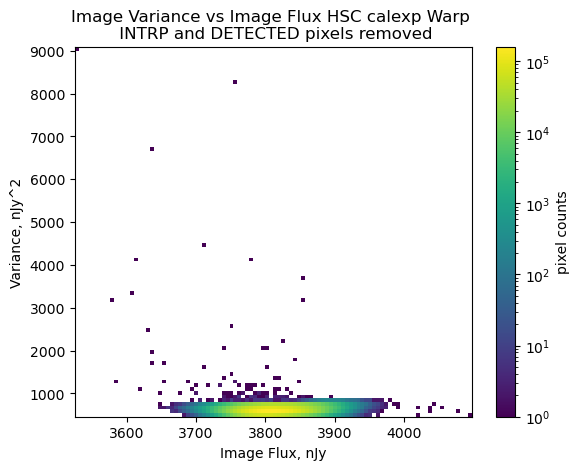

In [10]:
# plotting
plt.hist2d(warp_im_test, warp_var_test, bins=[100,100], norm="log")
plt.xlabel("Image Flux, nJy")
plt.ylabel("Variance, nJy^2")
plt.title("Image Variance vs Image Flux HSC calexp Warp \n INTRP and DETECTED pixels removed")
plt.colorbar(label="pixel counts")

## All pixels below 10,000
(because we do want to plot something readable)

In [11]:
warp_im_finite = warp_im[np.isfinite(warp_im)]
warp_var_finite = warp_var[np.isfinite(warp_var)]

warp_im_finite = warp_im_finite[np.where(warp_var_finite < 10000)]
warp_var_finite = warp_var_finite[np.where(warp_var_finite < 10000)]
warp_mask_finite = warp_mask[np.where(warp_var_finite < 10000)] # will need for later plots

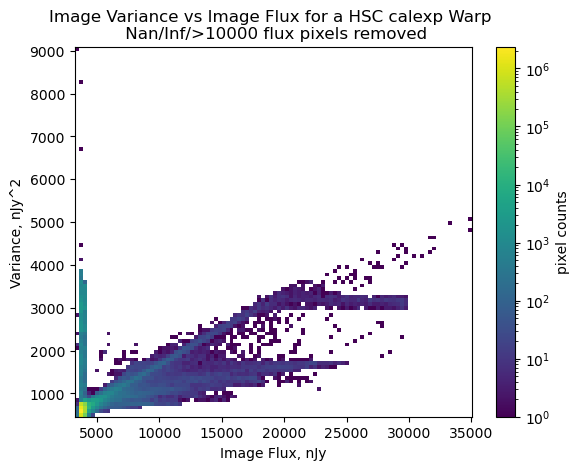

In [19]:
# plotting
plt.hist2d(warp_im_finite, warp_var_finite, bins=[100,100], norm="log")
plt.xlabel("Image Flux, nJy")
plt.ylabel("Variance, nJy^2")
plt.title("Image Variance vs Image Flux for a HSC calexp Warp \n Nan/Inf/>10000 flux pixels removed")
plt.colorbar(label="pixel counts")

## Remove `INTRP` pixels

This is a common mask that coincides with other masks; it's likely to cause much of the noise in the above plot.

You can find the bit value for a particular mask using the dictionary above.

In [13]:
mask_intrp = warp.mask.getPlaneBitMask('INTRP')

Remove pixels from the array that are covered by a particular mask. This should be done using `bitwise` operators as multiple masks may cover the same pixel.

Continue from the `warp_im_finite` and `warp_var_finite` arrays since we still only want to include finite and reasonable values for pixels

In [14]:
# mask arrays
warp_im_intrp = warp_im_finite[np.where(np.logical_not(np.bitwise_and(warp_mask_finite, mask_intrp)))]
warp_var_intrp = warp_var_finite[np.where(np.logical_not(np.bitwise_and(warp_mask_finite, mask_intrp)))]

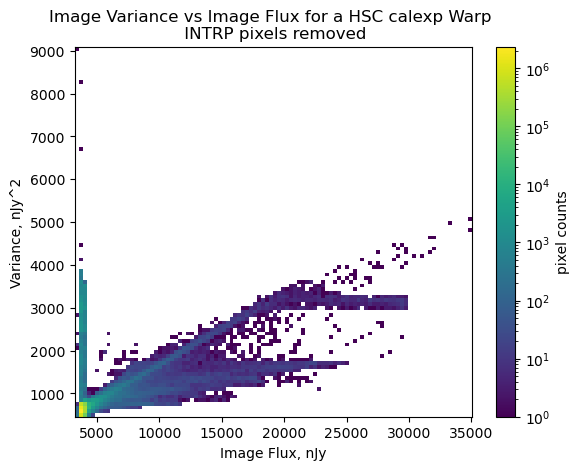

In [15]:
# plotting
plt.hist2d(warp_im_intrp, warp_var_intrp, bins=[100,100], norm="log")
plt.xlabel("Image Flux, nJy")
plt.ylabel("Variance, nJy^2")
plt.title("Image Variance vs Image Flux for a HSC calexp Warp \n INTRP pixels removed")
plt.colorbar(label="pixel counts")

## Remove `DETECTED` pixels

Same as above, just a different mask.

In [16]:
mask_detected = warp.mask.getPlaneBitMask('DETECTED')

In [17]:
# mask arrays
warp_im_detect = warp_im_finite[np.where(np.logical_not(np.bitwise_and(warp_mask_finite, mask_detected)))]
warp_var_detect = warp_var_finite[np.where(np.logical_not(np.bitwise_and(warp_mask_finite, mask_detected)))]

warp_im_finite = warp_im[np.where(warp_var < 10000)]
warp_var_finite = warp_var[np.where(warp_var < 10000)]

warp_im_finite = warp_im_finite[np.isfinite(warp_im_finite)]
warp_var_finite = warp_var_finite[np.isfinite(warp_var_finite)]

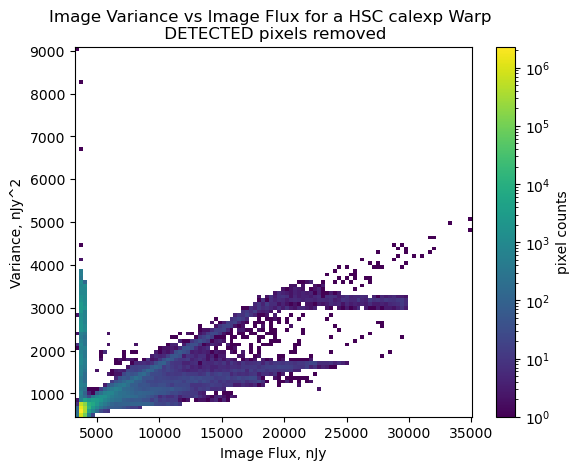

In [18]:
# plotting
plt.hist2d(warp_im_detect, warp_var_detect, bins=[100,100], norm="log")
plt.xlabel("Image Flux, nJy")
plt.ylabel("Variance, nJy^2")
plt.title("Image Variance vs Image Flux for a HSC calexp Warp \n DETECTED pixels removed")
plt.colorbar(label="pixel counts")

## Keep only unmasked pixels that are not part of a detected source.